In [3]:
include("../sym_cliff.jl")
using PyPlot

In [4]:
m2s(i) = div(i+1, 2)
s2m(i) = 2i-1

function spin_bmat(arcs)
    n = div(length(arcs), 2)
    mat = zeros(Bool, n, 2n)
    spin_arcs = zeros(Int, n, 2)
    l = 1
    for i in 1:2n
        j = arcs[i]
        (j<i) && continue
        si = m2s(i)
        sj = m2s(j)
        # @show si, sj
        # @show i%2, j%2
        if si==sj
            mat[l, i] = mat[l, j] = true
            spin_arcs[l, 1], spin_arcs[l, 2] = si, sj
        else
            if i%2 == 1
                mat[l, i+1] = mat[l, j] = true
                spin_arcs[l, 1], spin_arcs[l, 2] = sj, si
            else
                mat[l, i-1] = mat[l, j] = true
                spin_arcs[l, 1], spin_arcs[l, 2] = si, sj
            end
            mat[l, 2si+1:2sj-2] .= true
        end
        l += 1
    end
    return mat, spin_arcs
end

function rand_arcs(n)
    arcs = zeros(Int, 2n)
    tmp = zeros(Int, n, 2)
    tmp[:, 1] = 2 .* (1:n) .- 1
    tmp[:, 2] = 2 .* randperm(n)
    for i in 1:n
        a, b = tmp[i, 1], tmp[i, 2]
        arcs[a], arcs[b] = b, a
    end
    return tmp, arcs
end

function rand_arcs2(n)
    arcs = zeros(Int, 2n)
    tmp = reshape(randperm(2n), n, 2)
    for i in 1:n
        a, b = tmp[i, 1], tmp[i, 2]
        arcs[a], arcs[b] = b, a
    end
    return tmp, arcs
end

function draw_arcs(tmp)
    parc = matplotlib.patches.Arc
    fg, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.set_xlim(0, 2size(tmp, 1)+1)
    ax.set_ylim(0, size(tmp, 1))
    for i in 1:size(tmp, 1)
        a, b = tmp[i, :]
        c = (a+b)/2
        r = abs(a-b)
        arc = parc((c, 0), r, r, angle=0, theta1=0, theta2=180)
        ax.add_patch(arc)
    end
    return fg, ax
end
    
function draw_spin_arcs(tmp)
    parc = matplotlib.patches.Arc
    fg, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.set_xlim(0, size(tmp, 1)+1)
    ax.set_ylim(-size(tmp, 1)/2, size(tmp, 1)/2)
    for i in 1:size(tmp, 1)
        a, b = tmp[i, :]
        (a==b) && continue
        c = (a+b)/2
        r = abs(a-b)
        if a > b
            arc = parc((c, 0), r, r, angle=0, theta1=0, theta2=180)
        else
            arc = parc((c, 0), r, r, angle=0, theta1=180, theta2=360)
        end  
        ax.add_patch(arc)
    end
    return fg, ax
end

function search_epr!(state, left, right, epr_list)
    this_is_epr = true
    s = left
    while (s <= right)
        i, j = state[2s-1], state[2s]
        si, sj = div(i + 1, 2), div(j + 1, 2)
        if (si != s) && (si == sj) && (left <= si <= right)
            is_epr = search_epr!(state, min(si, s) + 1, max(si, s) - 1, epr_list)
            if is_epr 
                push!(epr_list, (s, si))
            end
            
            s = max(s, si) + 1
        else
            if (si < left) || (si > right) || (sj < left) || (sj > right)
                this_is_epr = false
            end
            s += 1
        end
    end
    return this_is_epr
end

function circle_decomp(spin_tmp)
    n = size(spin_tmp, 1)
    tmpp = zeros(Int, n, 2)
    
    for k in 1:size(spin_tmp, 1)
        a, b = spin_tmp[k, :]
        if tmpp[a, 1] == 0
            tmpp[a, 1] = b
        else
            tmpp[a, 2] = b
        end
        if tmpp[b, 1] == 0
            tmpp[b, 1] = a
        else
            tmpp[b, 2] = a
        end
    end
    
    circ_idx = zeros(Int, n)
    circ_next = zeros(Int, n)
    k = 1
    for i in 1:n
        if circ_idx[i] != 0
            continue
        end
        l = i
        while true
            circ_idx[l] = k
            if circ_idx[tmpp[l, 1]] == 0
                circ_next[l] = tmpp[l, 1]
                l = tmpp[l, 1]
            elseif circ_idx[tmpp[l, 2]] == 0
                circ_next[l] = tmpp[l, 2]
                l = tmpp[l, 2]
            else
                circ_next[l] = i
                break
            end
        end
        k = k+1
    end
    return circ_idx, circ_next
end


function prev_next(state)
    n = div(length(state), 2)
    prev = [0 for _ in 1:n]
    next = [0 for _ in 1:n]
    seen = [false for _ in 1:n]
    for i in 1:n
        (seen[i]) && continue
        j = i
        p = i
        while true
            a = state[2j]
            if a % 2 == 0
                b = a-1
            else
                b = a+1
            end
            j = div(b+1, 2)
            next[p] = j
            prev[j] = p
            seen[p] = seen[j] = true
            if j == i
                break
            end
            p = j
        end
    end
    return prev, next
end

        
function clm_mutual_mi_mn(state, x1, x2, x3, x4)
    n = div(length(state), 2)
    A = x1:x2
    B = x2+1:x3-1
    C = x3:x4
    D = union(1:x1-1, x4+1:n)
    cA, cC, cB, cAC, cD = 0, 0, 0, 0, 0
    prev, next = prev_next(state)
    seen = [false for _ in 1:n]
    for i in B
        seen[i] && continue
        be = i
            while (prev[be] in B)
                be = prev[be]
                if prev[be] == i
                    break
                end
            end

            if prev[be] == i
                while true
                    seen[be] = true
                    be = next[be]
                    if be==i
                        seen[be] = true
                        break
                    end
                end
                cB += 1
                continue
            end

            en = be
            while (next[en] in B)
                seen[en] = true
                en = next[en]
            end
            seen[en] = true

            b, e = prev[be], next[en]

            if (b in D) || (e in D)
                cD +=1
            elseif (b in A) && (e in A)
                cA +=1
            elseif (b in C) && (e in C)
                cC +=1
            elseif ((b in A) && (e in C))||((b in C) && (e in A))
                cAC +=1
            end
        end

        u = 0
        for i in A
            if prev[i] in C
                u += 1
            end
            if next[i] in C
                u += 1
            end
        end

        if cD > 0
            mi = max(0, u-1)
        elseif cAC % 2 == 0
            mi = u
        else
            mi = 1 + max(0, u-1)
        end

    if cD > 0
        mn = max(0, div(u-1, 2)*2)
    elseif cAC % 2 == 0
        mn = div(u, 2) * 2
    else
        mn =  max(0, div(u-1, 2)*2)
    end
    
    return mi, mn
end

clm_mutual_mi_mn (generic function with 1 method)

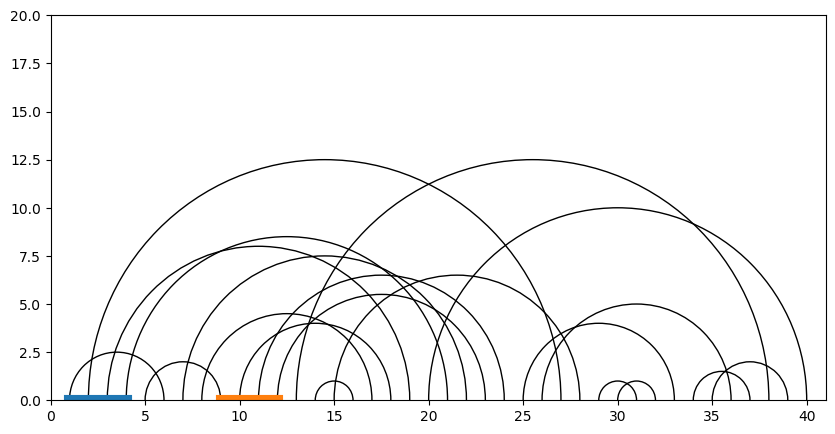

epr_list = Any[(15, 16)]


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002972AE48>

In [7]:
function a()
    for _ in 1:10000
        n = 20
        tmp, arcs = rand_arcs2(n)

        epr_list = []
        search_epr!(arcs, 1, n, epr_list)
        if !isempty(epr_list)
            @show epr_list
            fg, ax = draw_arcs(tmp)
             return fg, ax, tmp, arcs
        end
    end
end

fg,ax,tmp, arcs = a()
ax.plot(1:4, [0,0,0,0], linewidth=8)
ax.plot(9:12, [0,0,0,0], linewidth=8)


(mutual_info(state, [1], [3]), mutual_info(state, [2], [4])) = (0, 1)


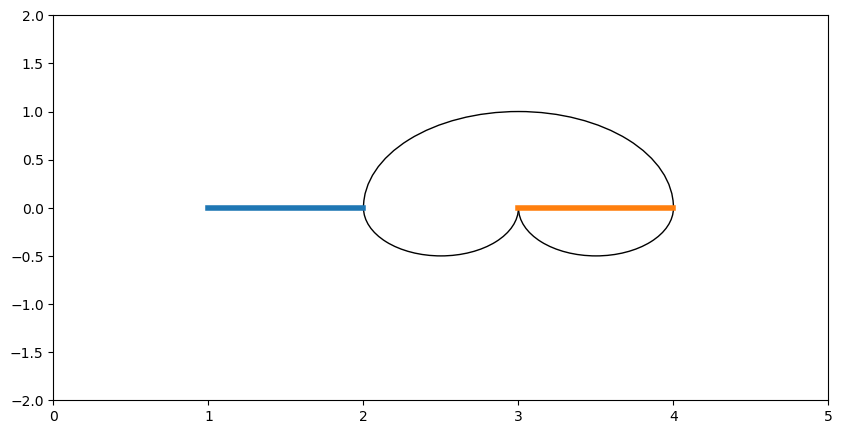

circle_decomp(spin_tmp) = ([1, 2, 2, 2], [1, 4, 2, 3])


([1, 2, 2, 2], [1, 4, 2, 3])

In [16]:
n = 4

tmp, arcs = rand_arcs(n)
bmat, spin_tmp = spin_bmat(arcs)
state = to_stablizer_state(bmat)
@show mutual_info(state, [1], [3]), mutual_info(state, [2], [4])
# @show mutual_neg(state, [1], [2]), mutual_neg(state, [3], [4]), mutual_neg(state, [1], [3]), mutual_neg(state, [2], [4])
fg, ax = draw_spin_arcs(spin_tmp)
ax.plot(1:2, [0, 0], linewidth=4)
ax.plot(3:4, [0, 0], linewidth=4)
@show circle_decomp(spin_tmp)

In [306]:
mutual_info(state, [1, 3], [2, 4])

4

mutual_info(state, [1, 2], [4, 5]) = 1
mutual_neg(state, [1, 2], [4, 5]) = 0

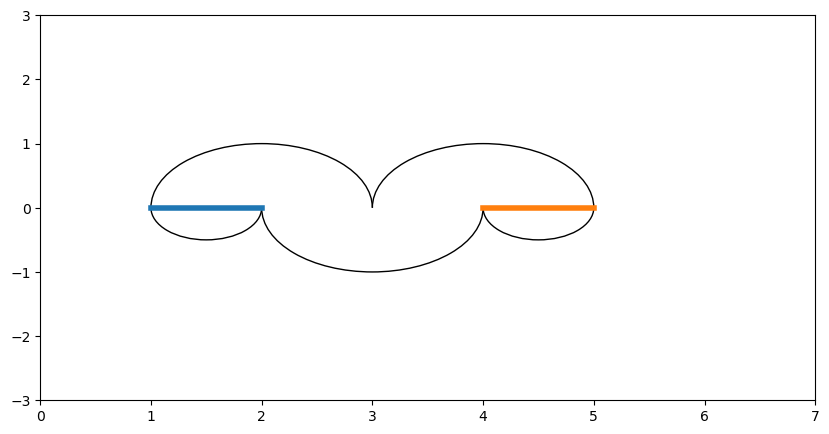


circle_decomp(spin_tmp) = ([1, 1, 1, 1, 1, 2], [3, 1, 5, 2, 4, 6])


([1, 1, 1, 1, 1, 2], [3, 1, 5, 2, 4, 6])

In [17]:
n = 6

tmp, arcs = rand_arcs(n)
bmat, spin_tmp = spin_bmat(arcs)
state = to_stablizer_state(bmat)
@show  mutual_info(state, [1,2], [4, 5])
@show mutual_neg(state, [1, 2], [4, 5])
fg, ax = draw_spin_arcs(spin_tmp)
ax.plot(1:2, [0, 0], linewidth=4)
# ax.plot(3:4, [0, 0], linewidth=4)
ax.plot(4:5, [0, 0], linewidth=4)
@show circle_decomp(spin_tmp)

In [315]:
state

6×6 Array{Paulis,2}:
 Z   Y   Z   II  II  II
 X   X   II  II  II  II
 II  X   Y   Y   Y   X 
 II  II  Z   Z   II  II
 II  II  II  Z   Z   II
 II  II  II  II  Z   Z 

mutual_info(state, 1:3, 6:7) = 

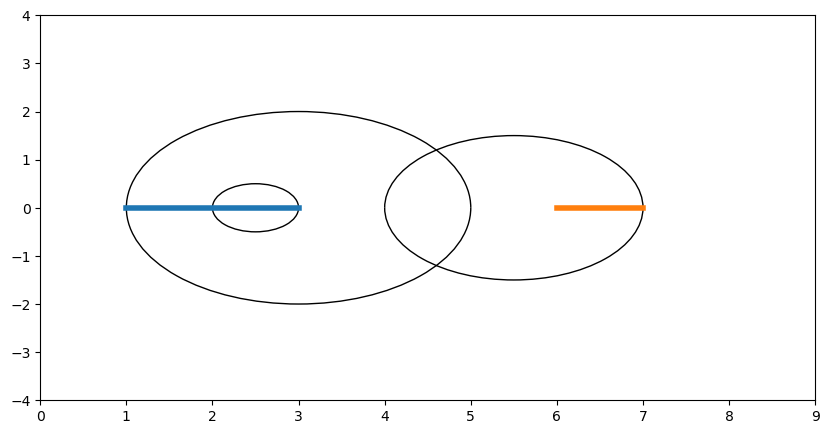

0


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002B95BD88>

In [8]:
n = 8

tmp, arcs = rand_arcs(n)
bmat, spin_tmp = spin_bmat(arcs)
state = to_stablizer_state(bmat)
@show mutual_info(state, 1:3, 6:7)
# @show mutual_neg(state, [1, 2], [3, 4]), mutual_neg(state, [1, 2], [4, 5])
fg, ax = draw_spin_arcs(spin_tmp)
ax.plot(1:3, [0, 0, 0], linewidth=4)
ax.plot(6:7, [0, 0], linewidth=4)

In [259]:
n = 6
tmp, arcs = rand_arcs(n)
bmat = spin_bmat(arcs)
state = to_stablizer_state(bmat)
@show mnAC, miAC = mutual_neg(state, 1:, 51:75), mutual_info(state, 1:25, 51:75)

# tmp = a()
fg, ax = draw_arcs(tmp)
# ax.plot(1:4, [0,0,0,0], linewidth=8)
# ax.plot(7:10, [0,0,0,0], linewidth=8)
# ax.plot(7:12, [0,0,0,0], linewidth=8)

# @show mutual_neg(state, B, D)
# parc = matplotlib.patches.Arc

LoadError: syntax: missing last argument in "1:" range expression 

In [228]:
mutual_info(state, [1], [2])

0

In [556]:
for i in 1:10000
    n = 100
    A = 1:30
    B = 31:50
    tmp, arcs = rand_arcs(n)
    bmat, spin_tmp = spin_bmat(arcs)
    state = to_stablizer_state(bmat)

    count = 0
    for i in 1:n
        x, y = spin_tmp[i, 1], spin_tmp[i, 2]
        if (x in A)&&(y in B)
            count +=1
        elseif (x in B)&&(y in A)
            count +=1
        end
    end
    if count- mutual_info(state, A, B) !=0
        @show tmp, arcs
    end
end

In [19]:
function a()
    n = 20
    A = 1:5
    B = 6:10
    C = 11:15
    D = 16:20
    
    for _ in 1:10000
        tmp, arcs = rand_arcs(n)
        bmat, spin_tmp = spin_bmat(arcs)
        state = to_stablizer_state(bmat)
        c = false
        
        for i in 1:n
            x, y = spin_tmp[i, 1], spin_tmp[i, 2]
            if (x in B) && (y in D)
                c = true
                break
            elseif (x in D) && (y in B)
                c = true
                break
            end
        end
        
        if !c
            continue
        end
        count = -1

        for i in 1:n
            x, y = spin_tmp[i, 1], spin_tmp[i, 2]
            if (x in A)&&(y in C)
                count +=1
            elseif (x in C)&&(y in A)
                count +=1
            end
        end
        
        if count < 0
            count = 0
        end
        
        mi = mutual_info(state, A, C)
        if mi !=count
            @show count, mi
            return tmp, arcs
        end
    end
end

tmp, arcs = a()

MethodError: MethodError: no method matching iterate(::Nothing)
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:604
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:604
  iterate(!Matched::ExponentialBackOff) at error.jl:214
  ...

MethodError: MethodError: no method matching iterate(::Nothing)
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:604
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:604
  iterate(!Matched::ExponentialBackOff) at error.jl:214
  ...

In [27]:
spin_tmp

12×2 Array{Int64,2}:
 11   1
  1  12
 10   2
  2   6
  3   3
  5   4
  4   9
  8   5
  6   7
  7   8
  9  11
 12  10

In [505]:
n = 6

tmp, arcs = rand_arcs(n)
bmat, spin_tmp = spin_bmat(arcs)
state = to_stablizer_state(bmat)
@show  mutual_info(state, [1,2], [4, 5])
@show mutual_neg(state, [1, 2], [4, 5])
fg, ax = draw_spin_arcs(spin_tmp)
ax.plot(1:2, [0, 0], linewidth=4)
# ax.plot(3:4, [0, 0], linewidth=4)
ax.plot(4:5, [0, 0], linewidth=4)

8×2 Array{Int64,2}:
 3  1
 1  2
 2  6
 7  3
 8  4
 4  8
 6  5
 5  7

In [34]:
function a()
    n = 60
    A = 1:15
    B = 16:30
    C = 31:45
    D = 46:60
    
    for _ in 1:10000
        tmp, arcs = rand_arcs(n)
        bmat, spin_tmp = spin_bmat(arcs)
        state = to_stablizer_state(bmat)
        _, next = circle_decomp(spin_tmp)
        prev = [0 for _ in next]
        [prev[next[i]] = i for i in next]    

        u = 0
        for i in A
            if prev[i] in C
                u += 1
            end
            if next[i] in C
                u += 1
            end
        end
        count = u
        
        mi = mutual_info(state, A, C)
        if abs(mi - count) > 1
            @show count, mi
            return tmp, arcs
        end
    end
end

tmp, arcs = a()
bmat, spin_tmp = spin_bmat(arcs)
fg, ax = draw_spin_arcs(spin_tmp)
ax.plot(1:3, [0,0,0])
ax.plot(7:9, [0,0,0])

MethodError: MethodError: no method matching iterate(::Nothing)
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:604
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:604
  iterate(!Matched::ExponentialBackOff) at error.jl:214
  ...